# ВКР: Разработка модели для оценки кредитоcпособности клиента

## Описание задачи

Модель машинного обучения для предсказания риска непогашения кредита на основе данных о его кредитной истории. Мы обучаем модель, которая будет предсказывать вероятность непогашения на основе различных признаков.

---

## Описание полей в данных

- **person_age** — возраст заемщика.
- **person_income** — годовой доход заемщика.
- **person_home_ownership** — тип жилья заемщика (например, `RENT` или `OWN`).
- **person_emp_length** — стаж работы заемщика в годах.
- **loan_intent** — цель кредита (например, `EDUCATION`, `BUSINESS`).
- **loan_grade** — категория кредита, например, `A`, `B`, `C`.
- **loan_amnt** — сумма кредита.
- **loan_int_rate** — процентная ставка по кредиту.
- **loan_status** — статус кредита (0 — точно выдаем, 1 — точно не выдем).
- **loan_percent_income** — доля дохода заемщика, которую он должен выплатить по кредиту.
- **cb_person_default_on_file** — информация о предыдущих дефолтах (N — нет, Y — да).
- **cb_person_cred_hist_length** — длина кредитной истории заемщика в годах.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, classification_report
import joblib

In [3]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 527.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 434.7 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 287.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 388.5 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 311.0 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 347.7 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 217.1 kB/s eta 0:00:00a 0:00:01


In [4]:
# === 1. Загрузка и предобработка данных ===
def load_and_preprocess_data(file_path):
    """
    Загружает данные, удаляет пропуски и кодирует категориальные признаки.
    :param file_path: Путь к CSV файлу с данными заемщиков
    :return: X (признаки), y (целевая переменная)
    """
    # Загрузка данных из CSV
    df = pd.read_csv(file_path)

    # Преобразование данных:
    # Удаляем строки с пропусками (можно модифицировать по необходимости)
    df = df.dropna()

    # Категориальные признаки, которые будем кодировать
    cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

    # Кодируем категориальные признаки с помощью one-hot encoding
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Целевая переменная — loan_status (0 = не дефолт, 1 = дефолт)
    X = df.drop("loan_status", axis=1)  # Признаки
    y = df["loan_status"]  # Цель

    return X, y


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# === 2. Обучение модели ===
def train_model(X_train, y_train):
    """
    Обучает модель случайного леса на тренировочных данных.
    :param X_train: Признаки для обучения
    :param y_train: Целевая переменная для обучения
    :return: Обученная модель
    """
    # Инициализация модели случайного леса
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Обучение модели
    model.fit(X_train, y_train)
    
    return model

In [11]:
# === 3. Оценка качества модели ===
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    roc_auc_score
)
import pandas as pd

def evaluate_model(model, X_test, y_test):
    """
    Оценивает модель на тестовых данных и выводит метрики и графики.
    Также возвращает ключевые значения для дальнейшего анализа.
    """
    # Предсказания
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Точность модели (Accuracy): {accuracy:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("Классификационный отчет:")
    print(pd.DataFrame(class_report).transpose())

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая модели')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Низкий риск", "Высокий риск"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Матрица ошибок")
    plt.grid(False)
    plt.show()

    # Важность признаков
    feat_imp_dict = {}
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature_names = X_test.columns if hasattr(X_test, "columns") else [f"feature_{i}" for i in range(X_test.shape[1])]
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

        plt.figure(figsize=(8, 6))
        feat_imp.plot(kind='barh')
        plt.title('Важность признаков (Feature Importance)')
        plt.xlabel('Значение важности')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        feat_imp_dict = feat_imp.to_dict()
    else:
        print("Важность признаков недоступна для данной модели.")

    # Возвращаем ключевые данные
    return {
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "confusion_matrix": cm.tolist(),
        "roc_curve": {
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "thresholds": thresholds.tolist()
        },
        "classification_report": class_report,
        "feature_importance": feat_imp_dict
    }


In [12]:
import joblib
import numpy as np

def save_model(model, X_sample, model_filename="/data/credit_model"):
    """
    Сохраняет модель и список признаков в формате .pkl.
    
    :param model: Обученная модель (например, RandomForestClassifier)
    :param X_sample: Пример входных данных (pandas DataFrame или numpy array)
    :param model_filename: Базовое имя файла без расширения
    """
    # Сохраняем модель
    model_path = f"{model_filename}.pkl"
    joblib.dump(model, model_path)
    print(f"✅ Модель сохранена в {model_path}")

    # Сохраняем список признаков
    if hasattr(X_sample, "columns"):
        feature_list = list(X_sample.columns)
    else:
        feature_list = [f"feature_{i}" for i in range(X_sample.shape[1])]
    
    feature_list_path = "/data/feature_list.pkl"
    joblib.dump(feature_list, feature_list_path)
    print(f"✅ Список признаков сохранён в {feature_list_path}")


In [13]:
# === 5. Функция для предсказания риска дефолта ===
def predict_default(input_dict, model_filename="/data/credit_model.pkl"):
    """
    Предсказывает риск дефолта для нового заемщика.
    :param input_dict: Словарь с данными заемщика
    :param model_filename: Путь к сохраненной модели
    :return: Предсказание модели
    """
    # Загрузка обученной модели
    model = joblib.load(model_filename)

    # Преобразование входных данных в DataFrame
    df_input = pd.DataFrame([input_dict])

    # Кодирование категориальных признаков
    cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
    df_input = pd.get_dummies(df_input, columns=cat_cols, drop_first=True)

    # Приводим признаки к тому же формату, что и при обучении
    feature_list = joblib.load("/data/feature_list.pkl")
    for col in feature_list:
        if col not in df_input.columns:
            df_input[col] = 0  # Добавляем отсутствующие признаки с значением 0
    df_input = df_input[feature_list]

    # Предсказание
    pred = model.predict(df_input)[0]
    prob = model.predict_proba(df_input)[0][1]

    if pred == 1:
        print(f"Высокий риск дефолта (вероятность: {prob:.2f})")
    else:
        print(f"Кредит можно выдать (вероятность дефолта: {prob:.2f})")

    return pred, prob

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_Y'],
      dtype='object')
Точность модели (Accuracy): 0.93
ROC AUC: 0.93
Классификационный отчет:
              precision    recall  f1-score      support
0              0.924675  0.991897  0.957107  4443.000000
1              0.962578  0.720623  0.824210  1285.000000
accuracy       0.931041  0.931041  0.931041     0.931041
macro avg      0.943626  0.856260  0.890659  5728.000000
weighted avg   0.933178  0.931041  0.927293  5728.000000


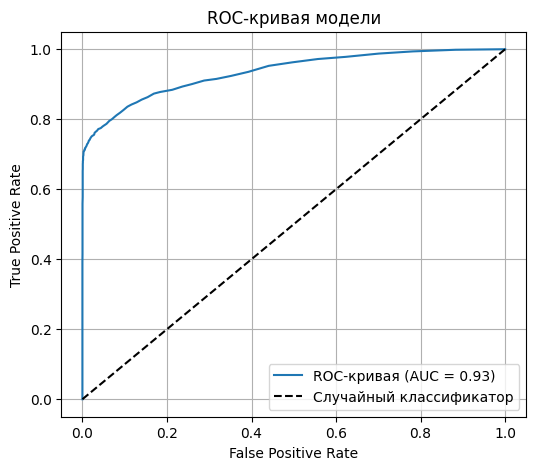

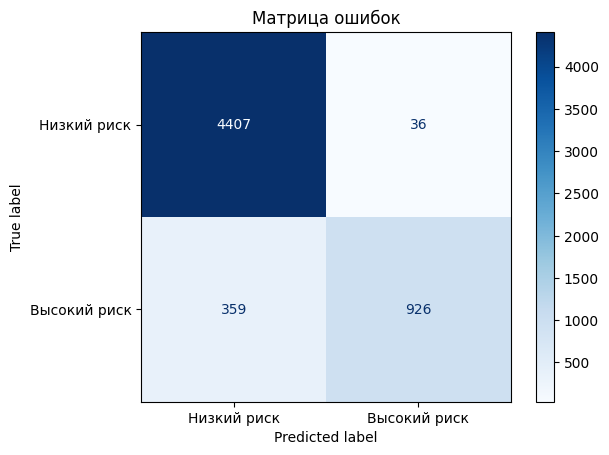

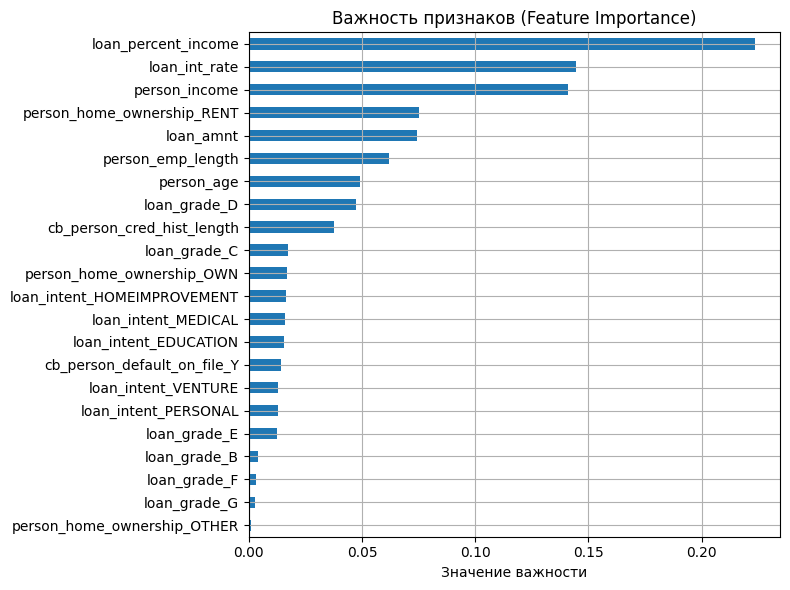

{'accuracy': 0.9310405027932961, 'roc_auc': np.float64(0.9349253098696766), 'confusion_matrix': [[4407, 36], [359, 926]], 'roc_curve': {'fpr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00022507314877335134, 0.00022507314877335134, 0.00022507314877335134, 0.00022507314877335134, 0.00022507314877335134, 0.00022507314877335134, 0.00022507314877335134, 0.00022507314877335134, 0.00022507314877335134, 0.00022507314877335134, 0.0006752194463200541, 0.0006752194463200541, 0.0006752194463200541, 0.0006752194463200541, 0.0006752194463200541, 0.0006752194463200541, 0.0006752194463200541, 0.0006752194463200541, 0.0006752194463200541, 0.0006752194463200541, 0.0009002925950934053, 0.0009002925950934053, 0.0009002925950934053, 0.0009002925950934053, 0.0011253657438667567, 0.0011253657438667567, 0.0015755120414134593, 0.0015755120414134593, 0.0015755120414134593, 0.0022507314877335135, 0.002475804636506865, 0.002475804636506865, 0.0027008777852802163, 0.0027008777852802163, 0.0031510240828269186

In [15]:
# === 6. Основная функция для выполнения всех шагов ===
def main():
    # Загружаем данные
    X, y = load_and_preprocess_data("/data/credit_risk_dataset.csv")

    print(X.columns)

    # Разделение данных на тренировочные и тестовые
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем модель
    model = train_model(X_train, y_train)

    # Оценка модели
    print(evaluate_model(model, X_test, y_test))
    
    # Сохранение модели
    save_model(model, X_sample=X[:1])

if __name__ == "__main__":
    main()

In [16]:
input_data_1 = {
    "person_age": 28,
    "person_income": 60000,  # Годовой доход
    "person_home_ownership": "RENT",  # Съемное жилье
    "person_emp_length": 3,  # Стаж работы
    "loan_intent": "EDUCATION",  # Цель кредита: образование
    "loan_grade": "A",  # Высокий рейтинг кредита
    "loan_amnt": 15000,  # Сумма кредита
    "loan_int_rate": 5.0,  # Процентная ставка
    "loan_percent_income": 0.25,  # 25% от дохода идет на кредит
    "cb_person_default_on_file": "N",  # Нет историй дефолтов
    "cb_preson_cred_hist_length": 4  # Кредитная история 4 года
}

# Получаем результат предсказания
predict_default(input_data_1)

Кредит можно выдать (вероятность дефолта: 0.05)


(np.int64(0), np.float64(0.05))

In [29]:
input_data_2 = {
    "person_age": 42,
    "person_income": 100000,  # Годовой доход
    "person_home_ownership": "OWN",  # Собственное жилье
    "person_emp_length": 15,  # Стаж работы
    "loan_intent": "BUSINESS",  # Цель кредита: бизнес
    "loan_grade": "B",  # Средний рейтинг кредита
    "loan_amnt": 30000,  # Сумма кредита
    "loan_int_rate": 8.0,  # Процентная ставка
    "loan_percent_income": 0.30,  # 30% от дохода идет на кредит
    "cb_person_default_on_file": "N",  # Нет историй дефолтов
    "cb_person_cred_hist_length": 10  # Кредитная история 10 лет
}

# Получаем результат предсказания
predict_default(input_data_2)

✅ Кредит можно выдать (вероятность дефолта: 0.07)


(0, 0.07)

In [30]:
input_data_3 = {
    "person_age": 36,
    "person_income": 25000,  # Годовой доход
    "person_home_ownership": "RENT",  # Съемное жилье
    "person_emp_length": 8,  # Стаж работы
    "loan_intent": "PERSONAL",  # Цель кредита: личные нужды
    "loan_grade": "C",  # Средний рейтинг кредита
    "loan_amnt": 10000,  # Сумма кредита
    "loan_int_rate": 15.0,  # Высокая процентная ставка
    "loan_percent_income": 0.40,  # 40% от дохода идет на кредит
    "cb_person_default_on_file": "Y",  # История дефолтов
    "cb_person_cred_hist_length": 5  # Кредитная история 5 лет
}

# Получаем результат предсказания
predict_default(input_data_3)

❌ Высокий риск дефолта (вероятность: 0.60)


(1, 0.6)

In [31]:
input_data_4 = {
    "person_age": 55,
    "person_income": 120000,  # Годовой доход
    "person_home_ownership": "OWN",  # Собственное жилье
    "person_emp_length": 30,  # Стаж работы
    "loan_intent": "HOME_PURCHASE",  # Цель кредита: покупка жилья
    "loan_grade": "A",  # Отличный рейтинг кредита
    "loan_amnt": 200000,  # Сумма кредита
    "loan_int_rate": 4.5,  # Низкая процентная ставка
    "loan_percent_income": 0.50,  # 50% от дохода идет на кредит
    "cb_person_default_on_file": "Y",  # Имел дефолты в прошлом
    "cb_person_cred_hist_length": 25  # Кредитная история 25 лет
}

# Получаем результат предсказания
predict_default(input_data_4)

✅ Кредит можно выдать (вероятность дефолта: 0.25)


(0, 0.25)